In [1]:
import numpy as np
import math
import random
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib import image
import cv2
import seaborn as sns

In [2]:
import sys
import import_ipynb
import os
os.getcwd() 
sys.path.append('C:/Users/AA086655/Documents/Assignment 3/')

from Methods import binarize,confusion_mat_seg, graph_cut,PSNR,plotHist
os.getcwd() 


importing Jupyter notebook from Methods.ipynb


'C:\\Users\\AA086655\\Documents\\Assignment 3\\Git'

In [3]:
img_path = 'images/testA_5.bmp'
anno_path = 'images/testA_5_anno.bmp'

img = cv2.imread(img_path, 0)
img_anno = cv2.imread(anno_path, 0)



<function matplotlib.pyplot.show(close=None, block=None)>

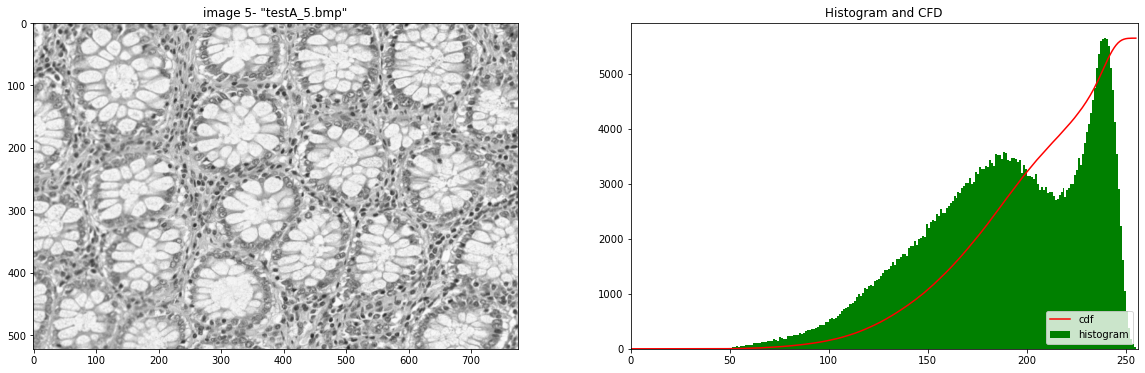

In [4]:
plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.imshow(img, cmap = 'gray', vmin = 0, vmax = 255 )
plt.title(label = 'image 5- "testA_5.bmp"')

plt.subplot(1,2,2)
plotHist(img,"False")
plt.title(label = 'Histogram and CFD')
plt.show

estimated noise standard deviation = 3.2728914769850572


<ipython-input-5-1b1e64902074>:18: UserWarning: Image dtype is not float. By default denoise_nl_means will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.19 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
  denoise = denoise_nl_means(noisy, h=20 * sigma_est, fast_mode=True,**patch_kw)


183.0
192.0


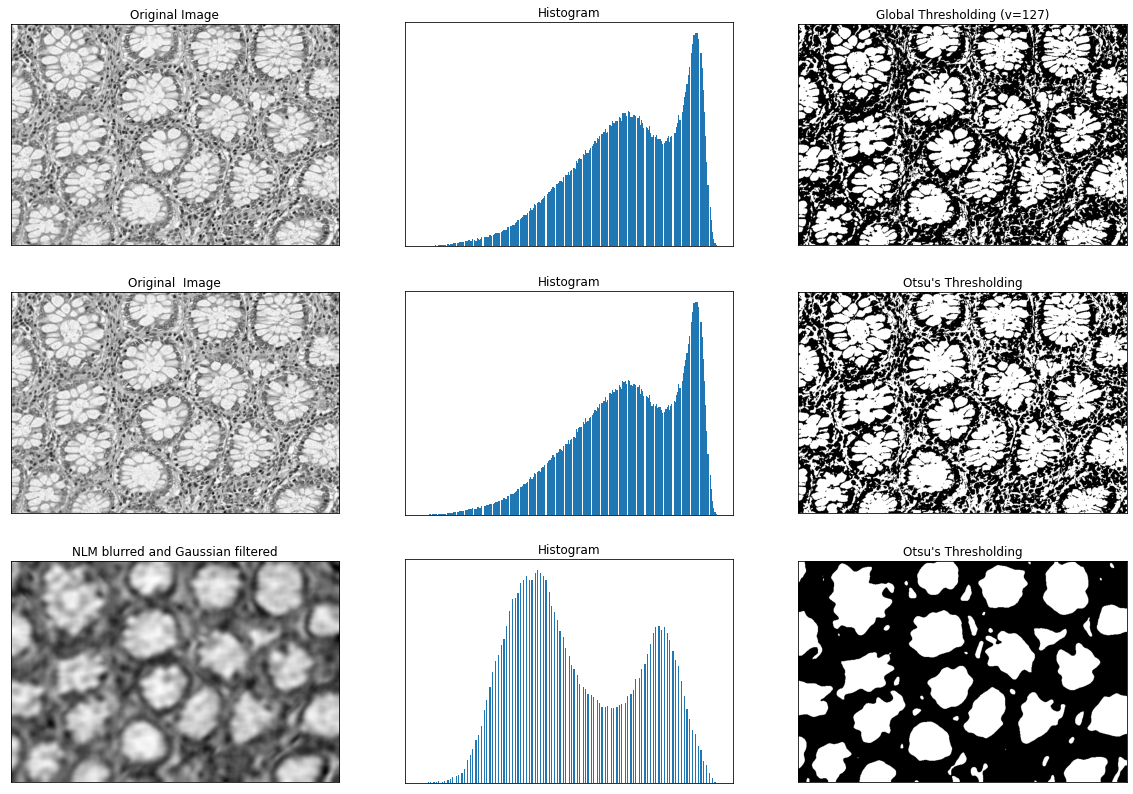

In [5]:
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise


sigma = 0.08
noisy = img

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(img))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(patch_size=20,      # 5x5 patches
                patch_distance=10)   # 13x13 search area)

# slow algorithm
denoise = denoise_nl_means(noisy, h=20 * sigma_est, fast_mode=True,**patch_kw)
denoise= denoise.astype('uint8')
#plt.imshow(denoise, cmap = 'gray', vmin = 0, vmax = 255)

blur = denoise #img
       
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(blur,(15,15),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret3,th3 = cv2.threshold(blur,192,255,cv2.THRESH_BINARY)


ret1,th1 = cv2.threshold(img,192,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret2)


print(ret3)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original  Image','Histogram',"Otsu's Thresholding",
          'NLM blurred and Gaussian filtered','Histogram',"Otsu's Thresholding"]
plt.figure(figsize = (20,14))

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

183.0
193.0


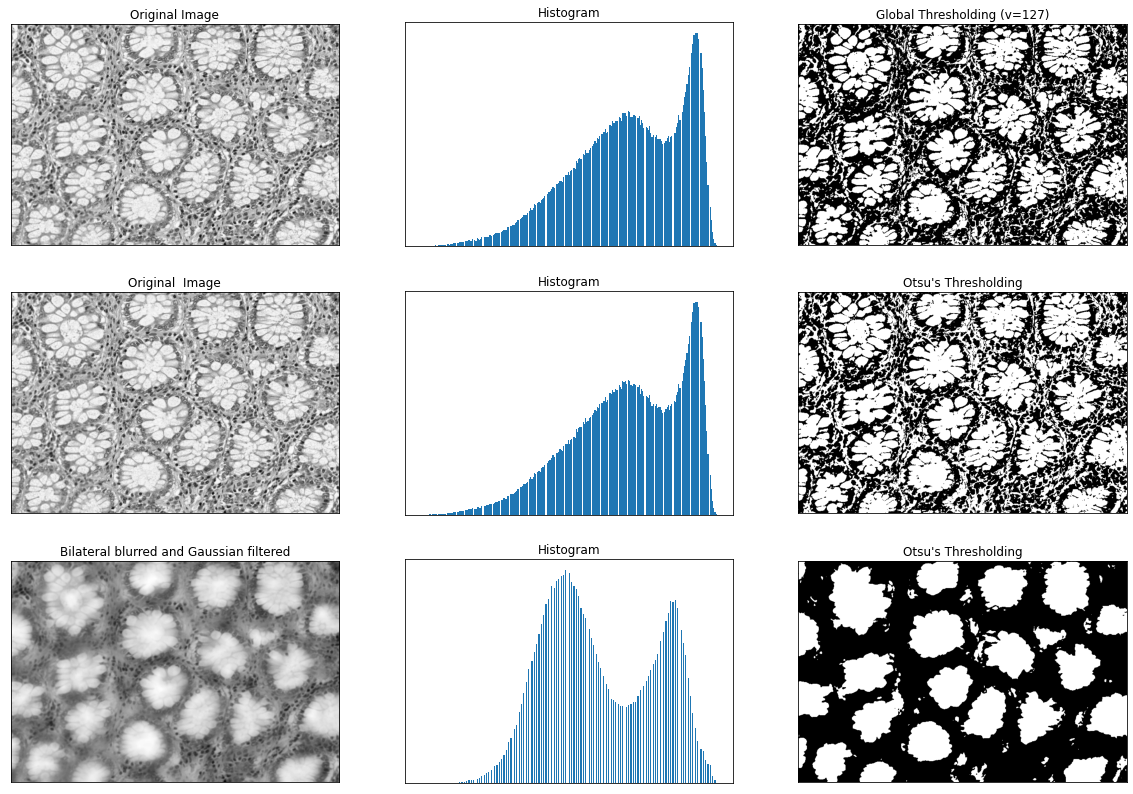

In [6]:
# global thresholding
#img = denoise #img

# Apply bilateral filter with d = 15, 
# s = sigmaColor = sigmaSpace = 75.
d=35;s=75
blur = cv2.bilateralFilter(img, d, s, s)
        
# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(blur,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#ret3,th3 = cv2.threshold(blur,192,255,cv2.THRESH_BINARY)


ret1,th1 = cv2.threshold(img,192,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(ret2)


print(ret3)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original  Image','Histogram',"Otsu's Thresholding",
          'Bilateral blurred and Gaussian filtered','Histogram',"Otsu's Thresholding"]
plt.figure(figsize = (20,14))

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

img_seg = th3

In [7]:
# Set total number of bins in the histogram
bins_num = 256

# Get the image histogram
hist, bin_edges = np.histogram(blur, bins=bins_num)

# Get normalized histogram if it is required
is_normalized = False
if is_normalized:
    hist = np.divide(hist.ravel(), hist.max())

# Calculate centers of bins
bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

# Iterate over all thresholds (indices) and get the probabilities w1(t), w2(t)
weight1 = np.cumsum(hist)
weight2 = np.cumsum(hist[::-1])[::-1]

# Get the class means mu0(t)
mean1 = np.cumsum(hist * bin_mids) / weight1
# Get the class means mu1(t)
mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

# Maximize the inter_class_variance function val
index_of_max_val = np.argmax(inter_class_variance)

threshold = bin_mids[:-1][index_of_max_val]
print("Otsu's algorithm implementation thresholding result: ", threshold)


Otsu's algorithm implementation thresholding result:  193.171875


<function matplotlib.pyplot.show(close=None, block=None)>

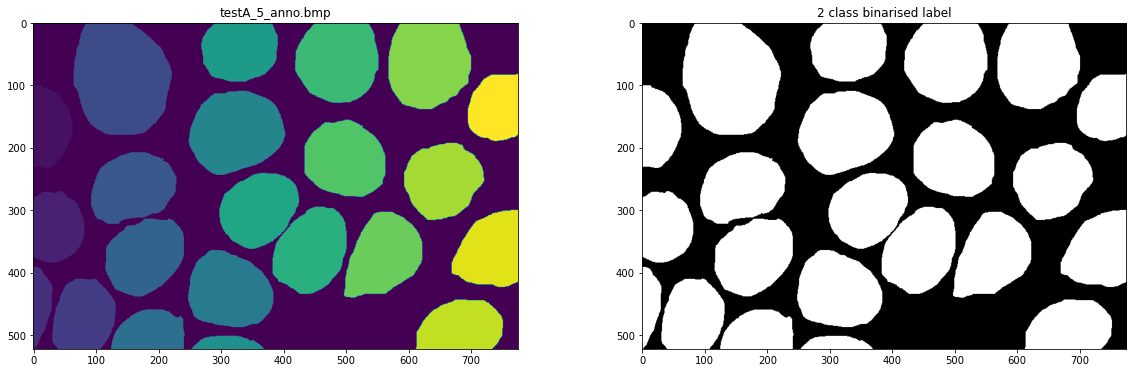

In [8]:
th,img_anno_2c =  cv2.threshold(img_anno, 0, 255, cv2.THRESH_BINARY)

plt.figure(figsize = (20,6))
plt.subplot(1,2,1)
plt.imshow(img_anno )
plt.title(label = 'testA_5_anno.bmp')

plt.subplot(1,2,2)
plt.imshow(img_anno_2c, cmap = 'gray', vmin = 0, vmax = 255)
plt.title(label = '2 class binarised label')
plt.show

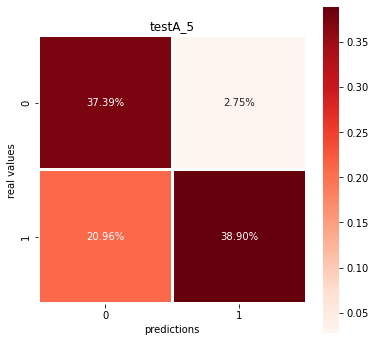

IoU score:  0.612027672141759 
F1 score: 0.7593265087423864 
Precision: 0.640822965777535 
Sensitivity: 0.9316020888242974 
Specificity: 0.6498542298131004 
Accuracy: 0.762948955629712


[0.612027672141759,
 0.7593265087423864,
 0.640822965777535,
 0.9316020888242974,
 0.6498542298131004,
 0.762948955629712]

In [9]:
confusion_mat_seg(img_anno_2c.astype('bool'), img_seg.astype('bool'), "testA_5")

C:\Users\AA086655\.conda\envs\tf-gpu\lib\site-packages\maxflow\fastmin.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  binary += V[labels[slice0],labels[slice1]].sum()


<function matplotlib.pyplot.show(close=None, block=None)>

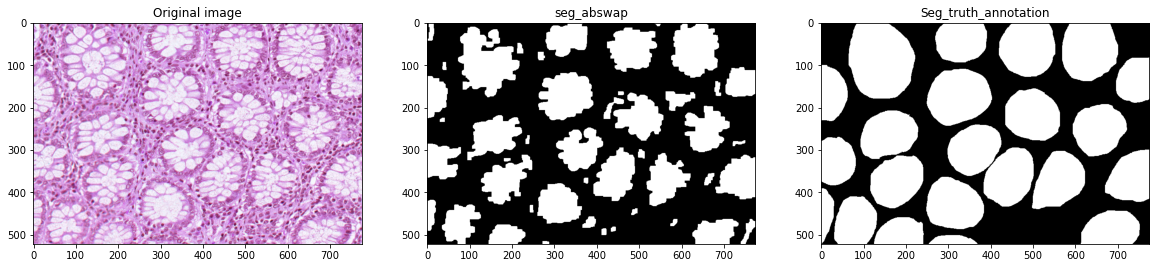

In [10]:
img_rgb = cv2.imread(img_path)

seg_abswap = graph_cut(img_rgb,"abswap_grid",0.92) #aexpansion_grid abswap_grid

plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.imshow(img_rgb, cmap = 'gray')
plt.title(label = 'Original image')

plt.subplot(1,3,2)
plt.imshow(seg_abswap, cmap = 'gray')
plt.title(label = 'seg_abswap')
plt.show

plt.subplot(1,3,3)
plt.imshow(img_anno_2c, cmap = 'gray')
plt.title(label = 'Seg_truth_annotation')
plt.show


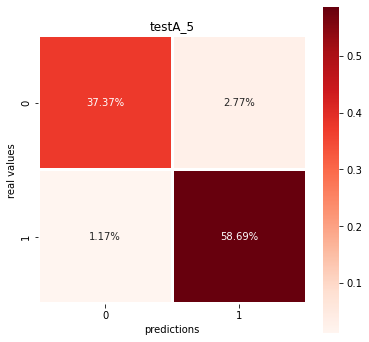

IoU score:  0.9047975249391109 
F1 score: 0.9500196352554939 
Precision: 0.9697338968810328 
Sensitivity: 0.9310909673128557 
Specificity: 0.980513044986414 
Accuracy: 0.9606748238783834


[0.9047975249391109,
 0.9500196352554939,
 0.9697338968810328,
 0.9310909673128557,
 0.980513044986414,
 0.9606748238783834]

In [11]:
confusion_mat_seg(seg_abswap.astype('bool'), img_seg.astype('bool'), "testA_5")

<function matplotlib.pyplot.show(close=None, block=None)>

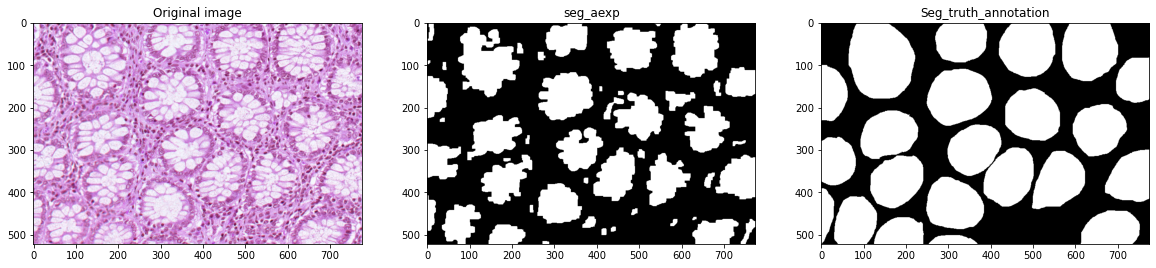

In [12]:
seg_aexp = graph_cut(img_rgb,"aexpansion_grid",0.915) #aexpansion_grid abswap_grid

plt.figure(figsize = (20,6))
plt.subplot(1,3,1)
plt.imshow(img_rgb, cmap = 'gray')
plt.title(label = 'Original image')

plt.subplot(1,3,2)
plt.imshow(seg_aexp, cmap = 'gray')
plt.title(label = 'seg_aexp')
plt.show

plt.subplot(1,3,3)
plt.imshow(img_anno_2c, cmap = 'gray')
plt.title(label = 'Seg_truth_annotation')
plt.show


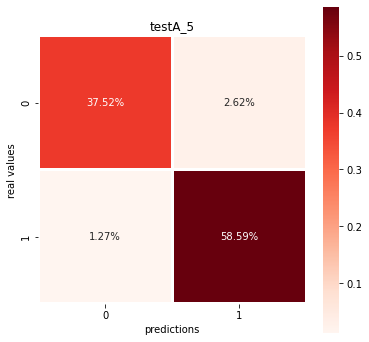

IoU score:  0.9060399479458924 
F1 score: 0.9507040489075967 
Precision: 0.9673056823106534 
Sensitivity: 0.9346626598024484 
Specificity: 0.9788158340284603 
Accuracy: 0.9610925719935731


[0.9060399479458924,
 0.9507040489075967,
 0.9673056823106534,
 0.9346626598024484,
 0.9788158340284603,
 0.9610925719935731]

In [13]:
confusion_mat_seg(seg_aexp.astype('bool'), img_seg.astype('bool'), "testA_5")